Based on the source: 
https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from torchsummary import summary

In [3]:
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        #----------------------------------------
        # Define the Neural Network Architecture
        #----------------------------------------
        
        super(ConvAutoencoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=8, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2)

    #----------------------------------------
    # Define the Neural Network
    #----------------------------------------
    def forward(self, x):
        x = F.gelu(self.conv1(x))
        x = self.pool(x)
        x = F.gelu(self.conv2(x))
        x = self.pool(x)
        x = F.gelu(self.conv3(x))
        x = self.pool(x)
        x = F.gelu(self.t_conv1(x))        
        x = F.gelu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))
        return x

#Instantiate the model
model = ConvAutoencoder()
n = 32
summary(model, (1,n,n))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
         AvgPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]           4,672
         AvgPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         AvgPool2d-6            [-1, 128, 4, 4]               0
   ConvTranspose2d-7             [-1, 64, 8, 8]          32,832
   ConvTranspose2d-8            [-1, 8, 16, 16]           2,056
   ConvTranspose2d-9            [-1, 1, 32, 32]              33
Total params: 113,529
Trainable params: 113,529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 0.43
Estimated Total Size (MB): 0.80
-------------------------------------------

In [4]:
#----------------------------------------
# Heuristic algorithm to draw given starting coordinate, the direction to take
# and number of steps to take. Each time the move function is called, it
# assigns a value inside the matrix image for coordinates calculated.
#----------------------------------------

def move(i,j,n,direction,step,t,v):
    if direction==0 and j+step<=n-1:#right
        for k in range(0,step):
            j=j+1
            t[i][j]=v 
    elif direction==1 and j-step>=0:#left
        for k in range(0,step):
            j=j-1
            t[i][j]=v
    elif direction==2 and i-step>=0:#up
        for k in range(0,step):
            i=i-1
            t[i][j]=v
    elif direction==3 and i+step<=n-1:#down
        for k in range(0,step):
            i=i+1
            t[i][j]=v
    return i,j

#----------------------------------------
# A helper function that checks if there is any path in its way of moving.
# The function often helps at creating cycles inside the maze problem.
#----------------------------------------
def inrange(i,j,direction,t):
    if direction==0 and (t[i+1][j]==0 or t[i][j+1]==0 or t[i-1][j]==0):
        return True
    elif direction==1 and (t[i+1][j]==0 or t[i][j-1]==0 or t[i-1][j]==0):
        return True
    elif direction==2 and (t[i][j-1]==0 or t[i+1][j]==0 or t[i][j+1]==0):
        return True
    elif direction==3 and (t[i][j-1]==0 or t[i-1][j]==0 or t[i][j+1]==0):
        return True
    return False

def generate_Solution(i,j,n,solution):    
#----------------------------------------
# Create the Solution First: 1 x n x n
# the solution is also known as the target image where
# the neural net will use to learn from in the training
#----------------------------------------
    solution[i][j]=0
    while (i!=0 or j!=n-1):
        direction=random.choice([0,2])
        step=random.choice([1,1,2,3])
        i,j=move(i,j,n,direction,step,solution,0)
    return solution

def generate_Problem(i,j,n,problem):
#---------------------------------------------------
# Create the Problem Based on Solution: 1 x n x n
# the problem is also known as the input image where 
# the neural net will take as input while training
#---------------------------------------------------
    branchcount=random.randint(5,6)
    branchcoords=random.sample(range(5, n-5,2),branchcount)
    for coord in branchcoords:
        for y in range(n-1):
            if problem[y][coord]==0:
                i=y
                j=coord
                alternative=random.randint(0,1)#left up if 0, right down if 1
                #start drawing line
                while ((0<i and i<n-1 and j!=0) or (0<j and j<n-1 and i!=0)):
                    if alternative==1:
                        direction=random.choice([1,2])
                    else:
                        direction=random.choice([0,3])
                    step=random.choice([1,1,2,3])
                    i,j=move(i,j,n,direction,step,problem,0)
                break
    for coords in branchcoords:
        for x in range(n-1):
            if problem[coord][x]==0:
                i=coord
                j=x
                alternative=random.randint(0,1)#left up if 0, right down if 1
                #start drawing line
                while ((0<i and i<n-1 and j!=0) or (0<j and j<n-1 and i!=0) and (not inrange(i,j,direction,problem))):
                    if alternative==1:
                        direction=random.choice([0,2])
                    else:
                        direction=random.choice([1,3])
                    step=random.choice([1,1,2,3])
                    i,j=move(i,j,n,direction,step,problem,0)
                break
    return problem

In [5]:
n=32
m=10000
#-----------------------------------------------------------------
# Create 10000 x 1 x 32 x 32 training input and target pairs
#-----------------------------------------------------------------
mazes = torch.zeros(m,1,n,n)
sols = torch.zeros(m,1,n,n)
for k in range(m):
    solution = torch.ones(n,n)
    problem = torch.ones(n,n)
    i,j=n-1,0
    solution=generate_Solution(i,j,n,solution)
    i,j=n-1,0
    problem=generate_Problem(i,j,n,solution.clone())

    mazes[k,0]=problem
    sols[k,0]=solution

#load data
dataset = torch.utils.data.TensorDataset(mazes, sols)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0)

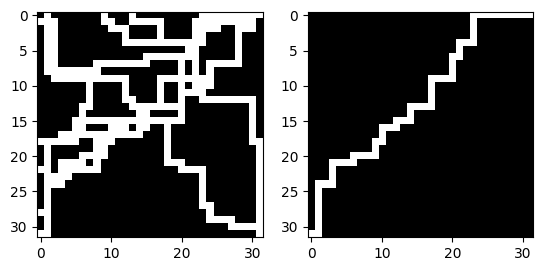

In [5]:
testMaze=torch.ones(1,n,n)
testSol=torch.ones(n,n) 

testSol=generate_Solution(n-1,0,n,testSol)
testMaze[0] = generate_Problem(n-1,0,n,testSol.clone())

fig, axes = plt.subplots(1,2)
axes[0].imshow(testMaze[0,:,:],cmap='binary')
axes[1].imshow(testSol,cmap='binary')

cpu
Epoch: 1 	Training Loss: 7.481828


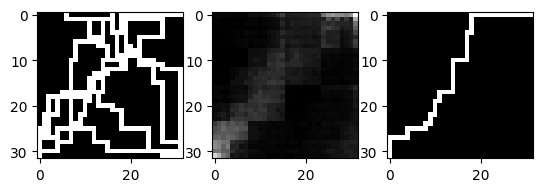

Epoch: 2 	Training Loss: 5.183299


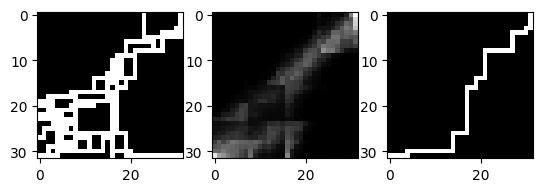

Epoch: 3 	Training Loss: 4.542024


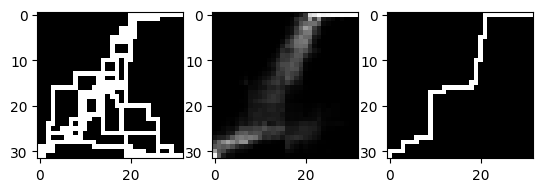

Epoch: 4 	Training Loss: 4.247477


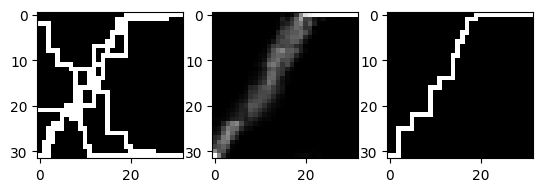

Epoch: 5 	Training Loss: 4.049121


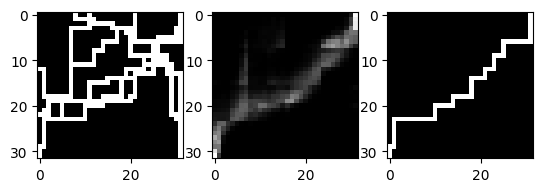

Epoch: 6 	Training Loss: 3.878035


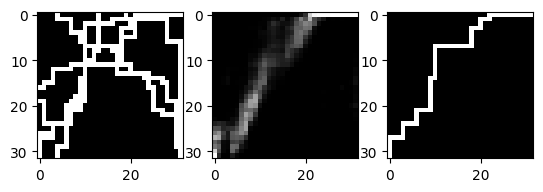

Epoch: 7 	Training Loss: 3.727361


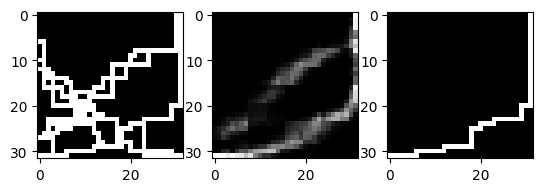

Epoch: 8 	Training Loss: 3.588731


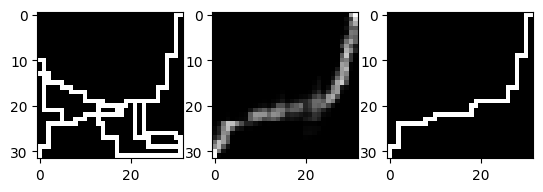

Epoch: 9 	Training Loss: 3.458978


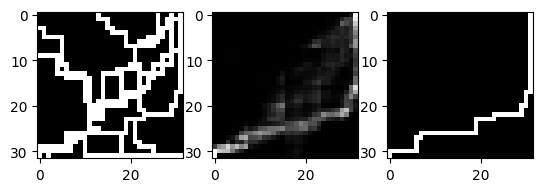

Epoch: 10 	Training Loss: 3.338717


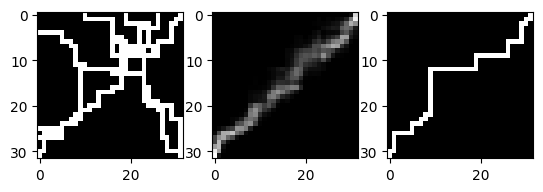

Epoch: 11 	Training Loss: 3.226486


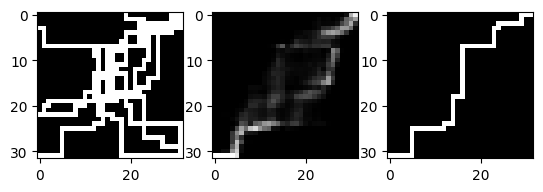

Epoch: 12 	Training Loss: 3.118547


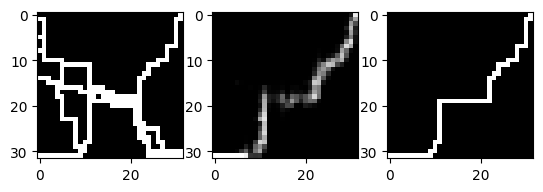

Epoch: 13 	Training Loss: 3.010774


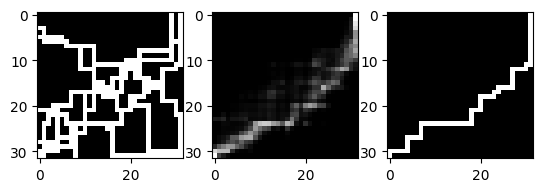

Epoch: 14 	Training Loss: 2.901462


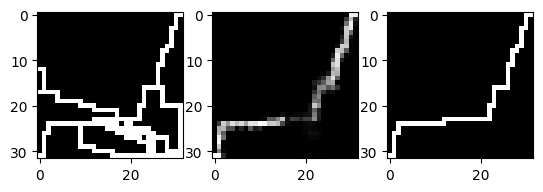

Epoch: 15 	Training Loss: 2.791059


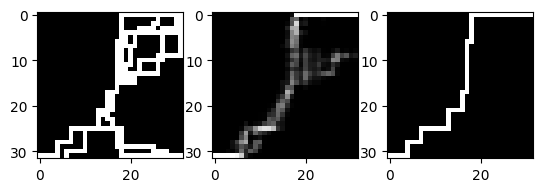

Epoch: 16 	Training Loss: 2.684639


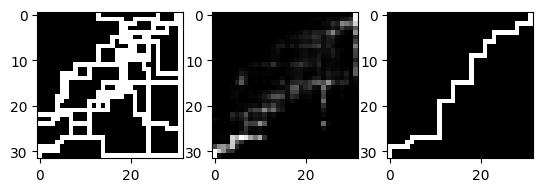

Epoch: 17 	Training Loss: 2.589820


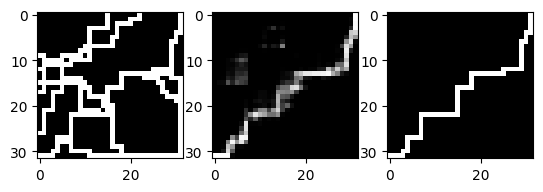

Epoch: 18 	Training Loss: 2.510252


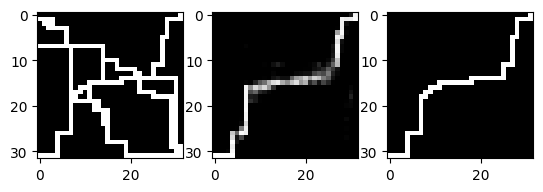

Epoch: 19 	Training Loss: 2.444901


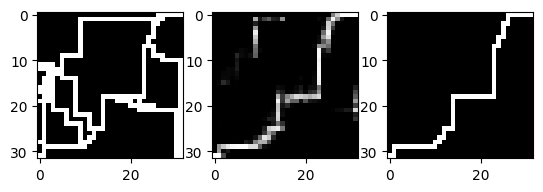

Epoch: 20 	Training Loss: 2.390041


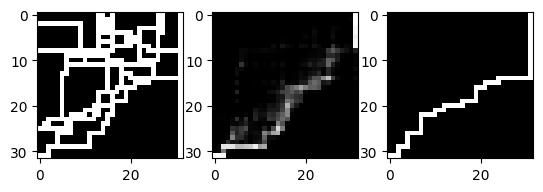

Epoch: 21 	Training Loss: 2.342602


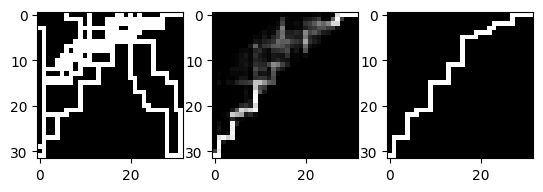

Epoch: 22 	Training Loss: 2.300643


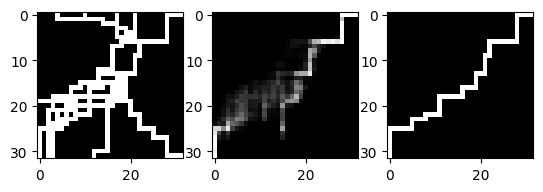

Epoch: 23 	Training Loss: 2.262754


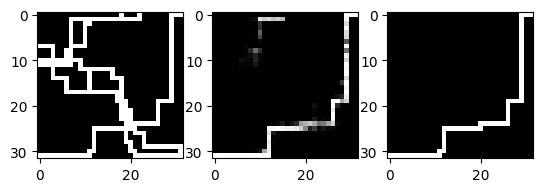

Epoch: 24 	Training Loss: 2.227876


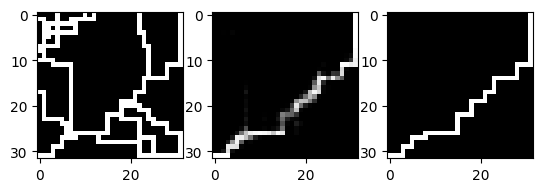

Epoch: 25 	Training Loss: 2.195489


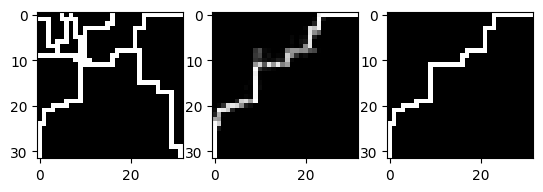

Epoch: 26 	Training Loss: 2.165312


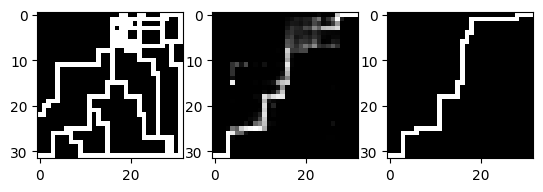

Epoch: 27 	Training Loss: 2.137066


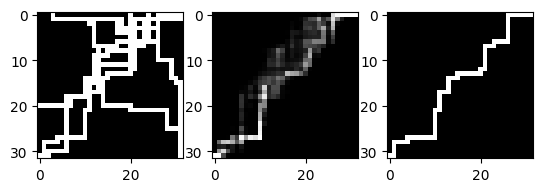

Epoch: 28 	Training Loss: 2.110506


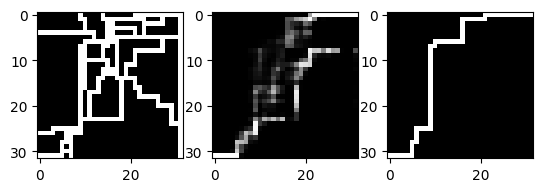

Epoch: 29 	Training Loss: 2.085424


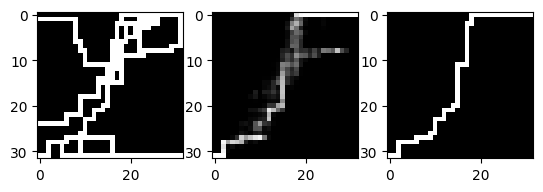

Epoch: 30 	Training Loss: 2.061651


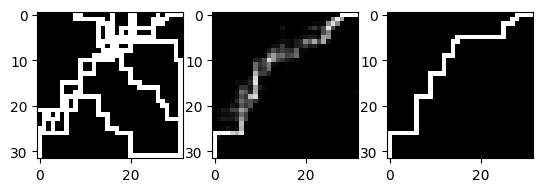

Epoch: 31 	Training Loss: 2.039041


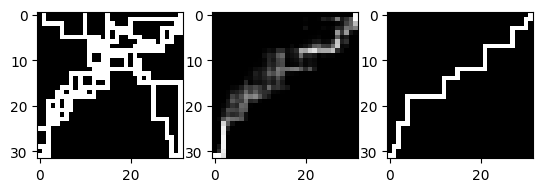

Epoch: 32 	Training Loss: 2.017464


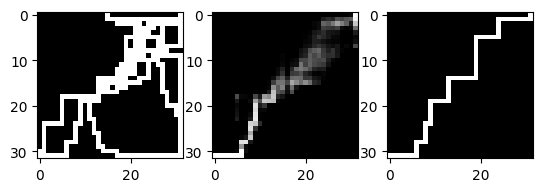

Epoch: 33 	Training Loss: 1.996814


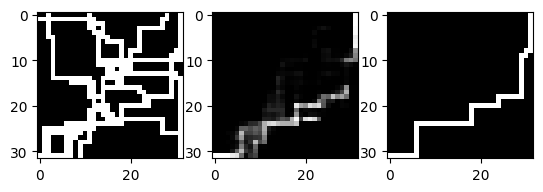

Epoch: 34 	Training Loss: 1.976987


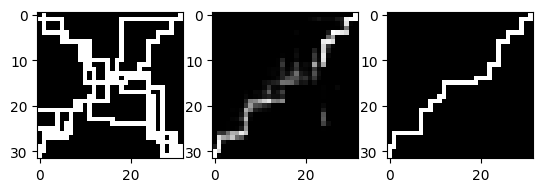

Epoch: 35 	Training Loss: 1.957897


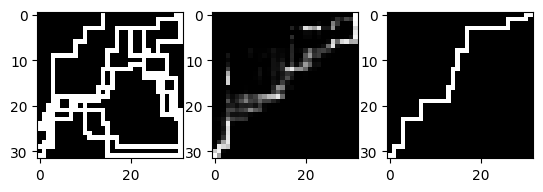

Epoch: 36 	Training Loss: 1.939466


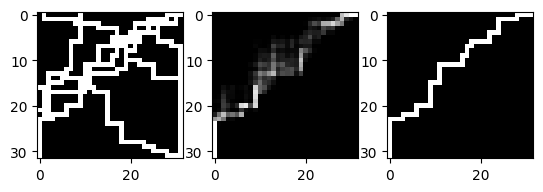

Epoch: 37 	Training Loss: 1.921635


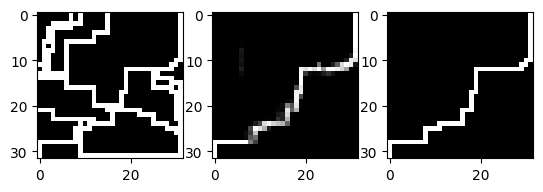

Epoch: 38 	Training Loss: 1.904349


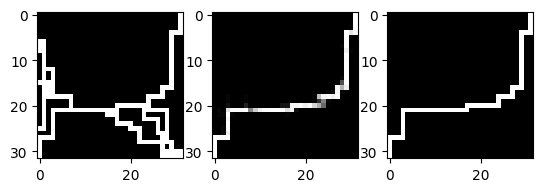

Epoch: 39 	Training Loss: 1.887558


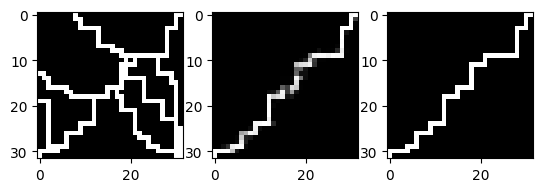

Epoch: 40 	Training Loss: 1.871215


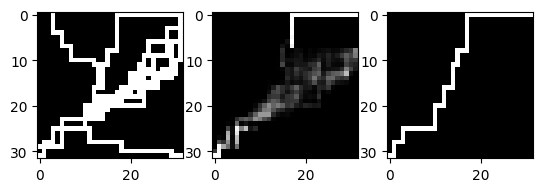

Epoch: 41 	Training Loss: 1.855276


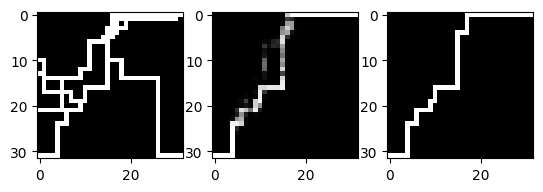

Epoch: 42 	Training Loss: 1.839702


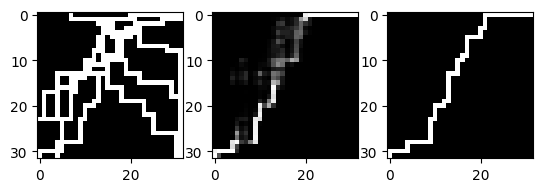

Epoch: 43 	Training Loss: 1.824457


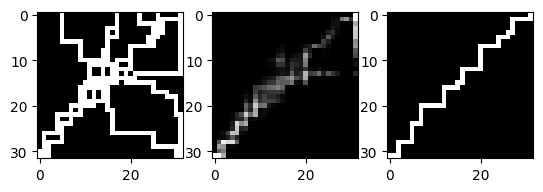

Epoch: 44 	Training Loss: 1.809511


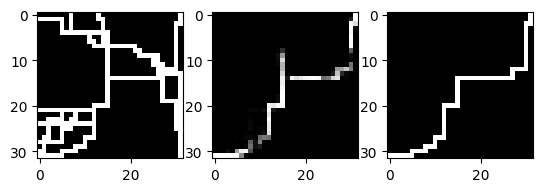

Epoch: 45 	Training Loss: 1.794839


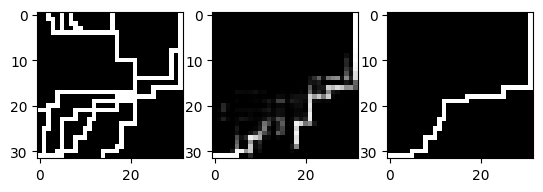

Epoch: 46 	Training Loss: 1.780430


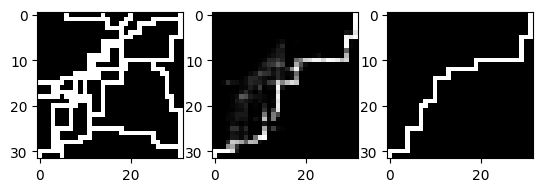

Epoch: 47 	Training Loss: 1.766276


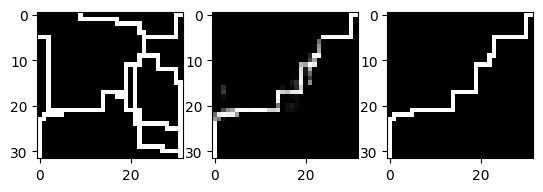

Epoch: 48 	Training Loss: 1.752379


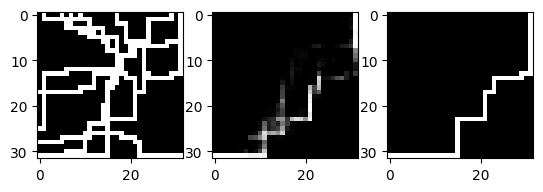

Epoch: 49 	Training Loss: 1.738742


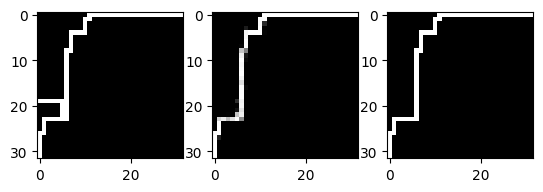

Epoch: 50 	Training Loss: 1.725362


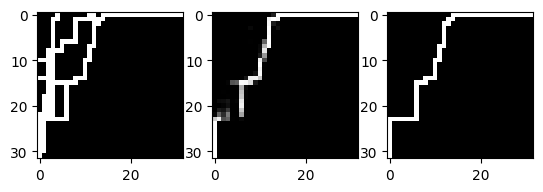

Epoch: 51 	Training Loss: 1.712229


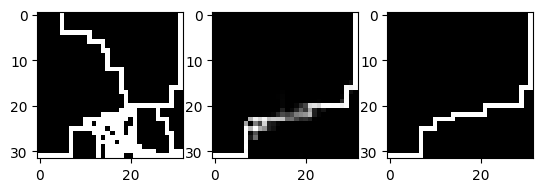

Epoch: 52 	Training Loss: 1.699327


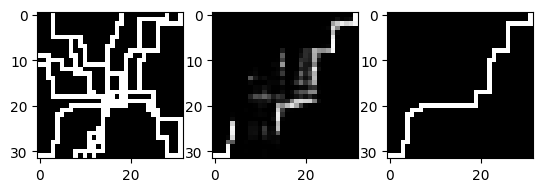

Epoch: 53 	Training Loss: 1.686638


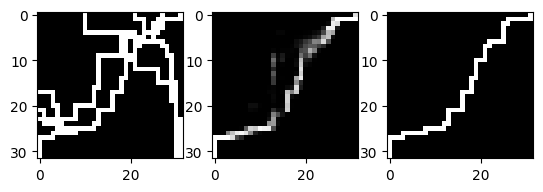

Epoch: 54 	Training Loss: 1.674145


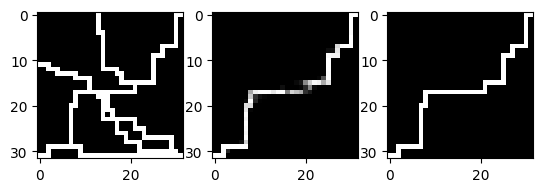

Epoch: 55 	Training Loss: 1.661833


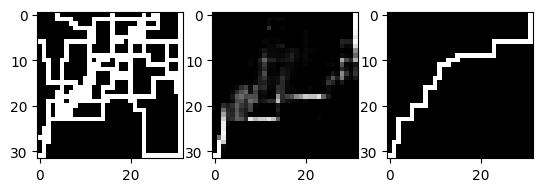

Epoch: 56 	Training Loss: 1.649688


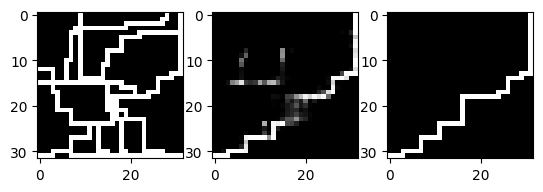

Epoch: 57 	Training Loss: 1.637706


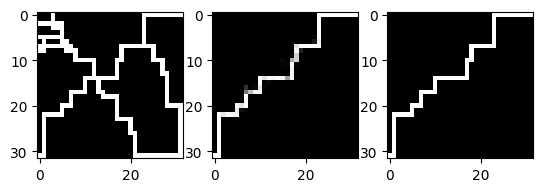

Epoch: 58 	Training Loss: 1.625887


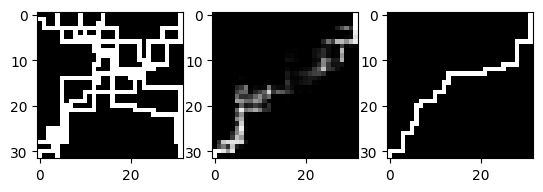

Epoch: 59 	Training Loss: 1.614235


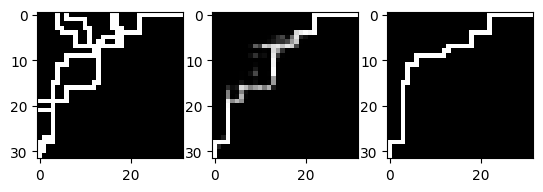

Epoch: 60 	Training Loss: 1.602762


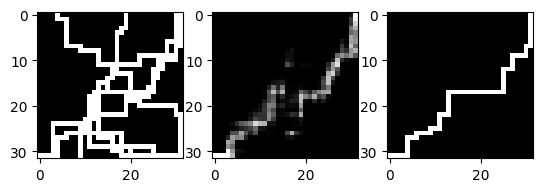

Epoch: 61 	Training Loss: 1.591481


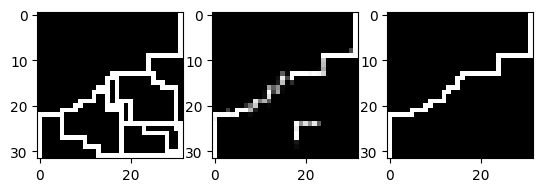

Epoch: 62 	Training Loss: 1.580409


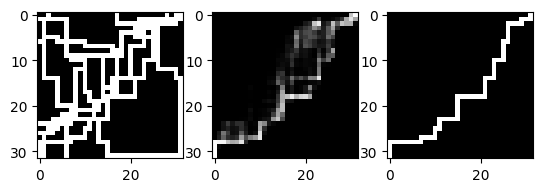

Epoch: 63 	Training Loss: 1.569568


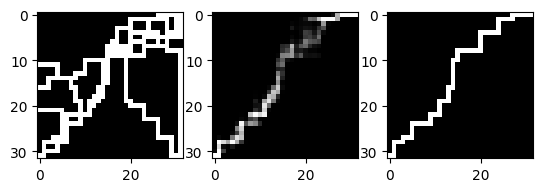

Epoch: 64 	Training Loss: 1.558982


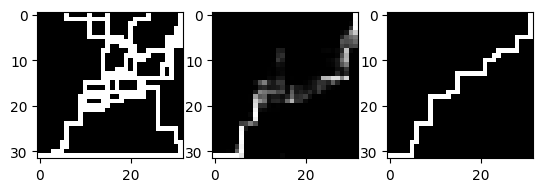

Epoch: 65 	Training Loss: 1.548680


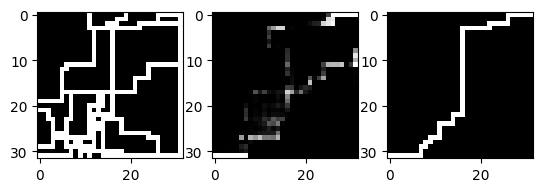

Epoch: 66 	Training Loss: 1.538693


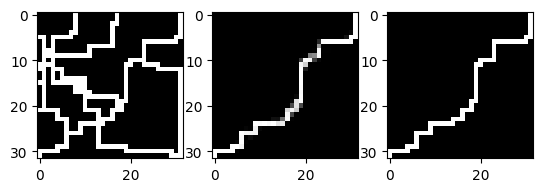

Epoch: 67 	Training Loss: 1.529048


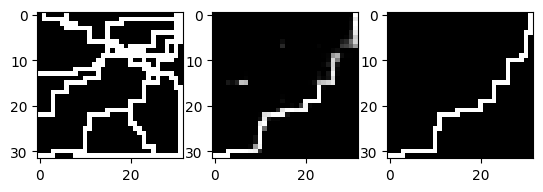

Epoch: 68 	Training Loss: 1.519773


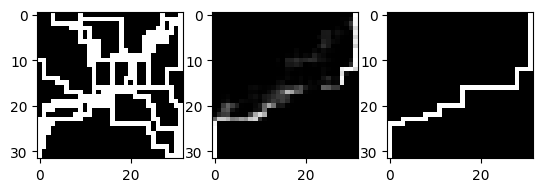

Epoch: 69 	Training Loss: 1.510903


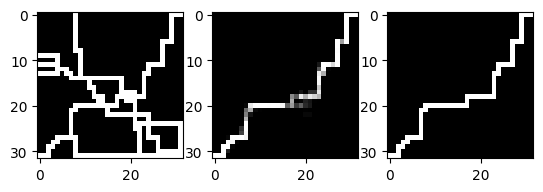

Epoch: 70 	Training Loss: 1.502477


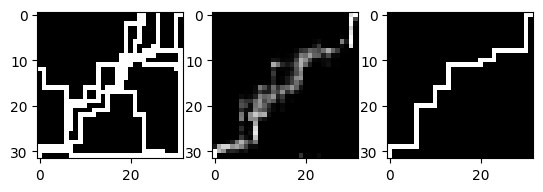

Epoch: 71 	Training Loss: 1.494540


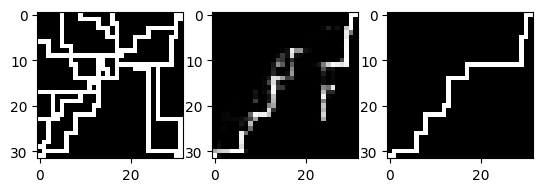

Epoch: 72 	Training Loss: 1.487130


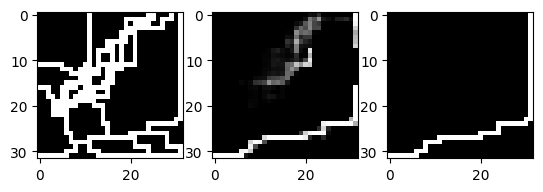

Epoch: 73 	Training Loss: 1.480291


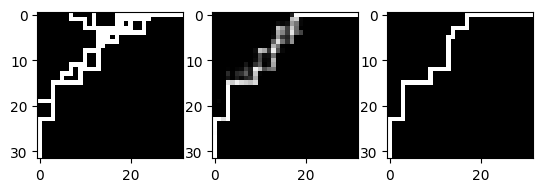

Epoch: 74 	Training Loss: 1.474044


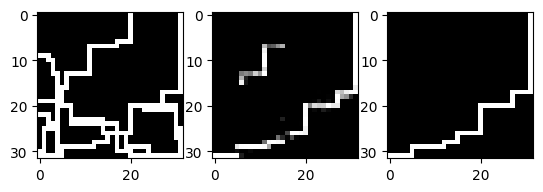

Epoch: 75 	Training Loss: 1.468281


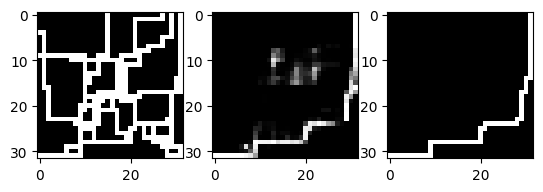

Epoch: 76 	Training Loss: 1.462524


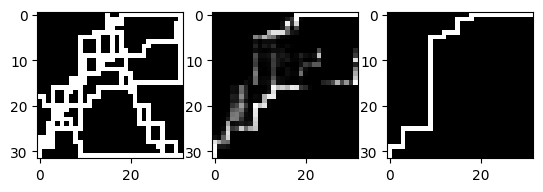

Epoch: 77 	Training Loss: 1.455603


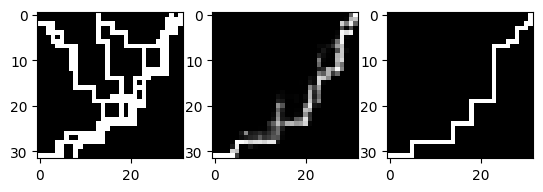

Epoch: 78 	Training Loss: 1.445425


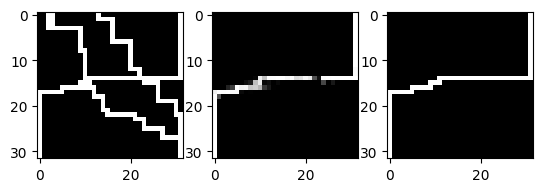

Epoch: 79 	Training Loss: 1.432251


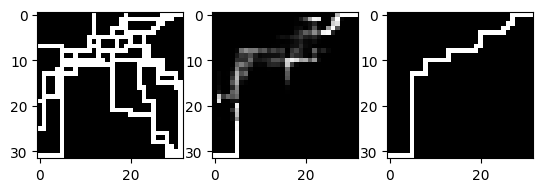

Epoch: 80 	Training Loss: 1.419208


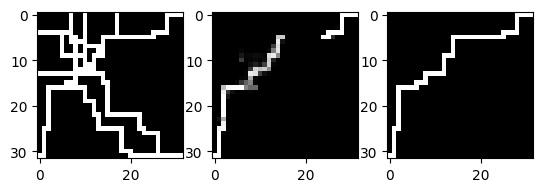

Epoch: 81 	Training Loss: 1.407314


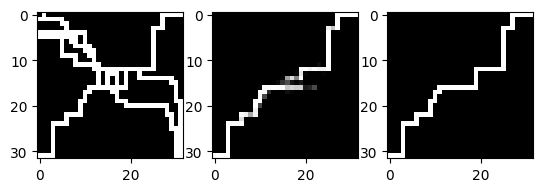

Epoch: 82 	Training Loss: 1.396446


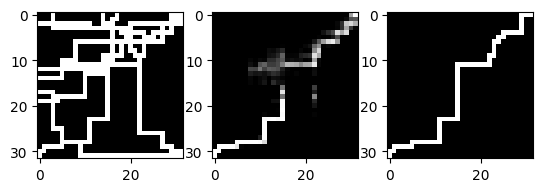

Epoch: 83 	Training Loss: 1.386352


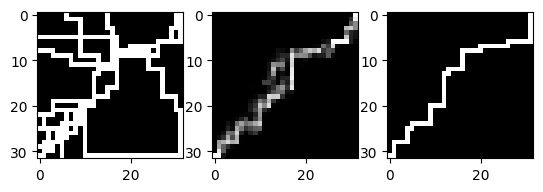

Epoch: 84 	Training Loss: 1.376820


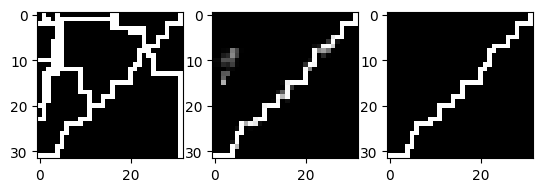

Epoch: 85 	Training Loss: 1.367701


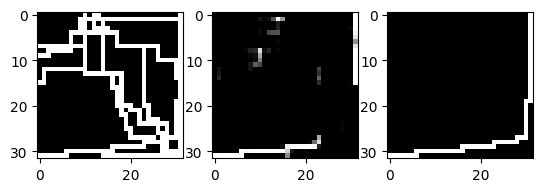

Epoch: 86 	Training Loss: 1.358905


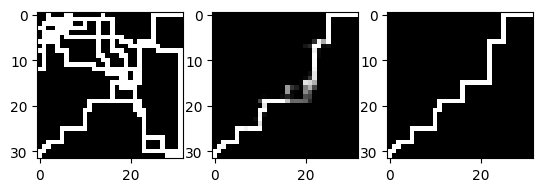

Epoch: 87 	Training Loss: 1.350373


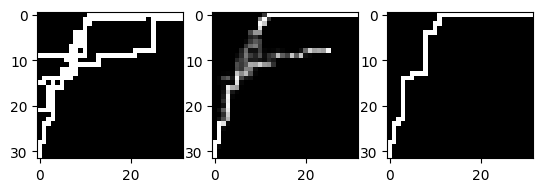

Epoch: 88 	Training Loss: 1.342063


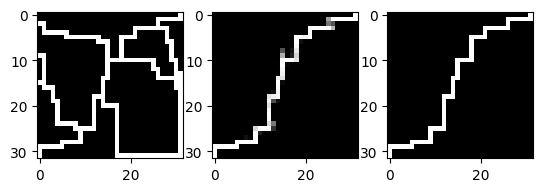

Epoch: 89 	Training Loss: 1.333973


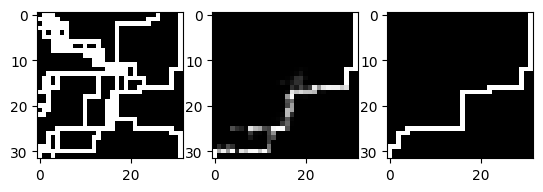

Epoch: 90 	Training Loss: 1.326085


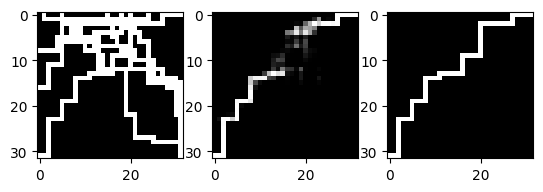

Epoch: 91 	Training Loss: 1.318377


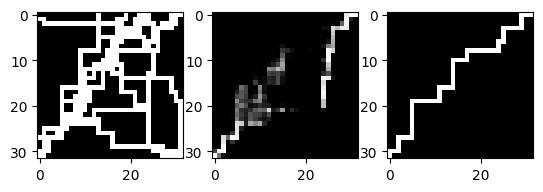

Epoch: 92 	Training Loss: 1.310867


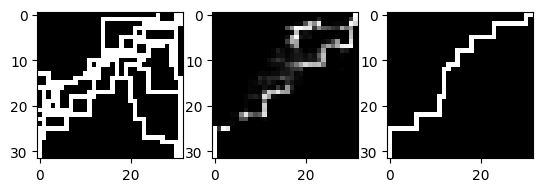

Epoch: 93 	Training Loss: 1.303540


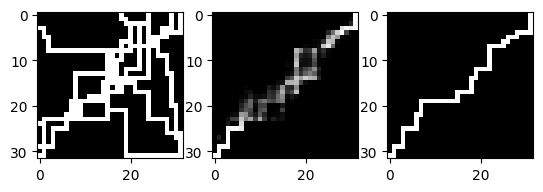

Epoch: 94 	Training Loss: 1.296399


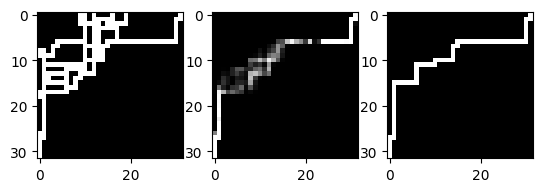

Epoch: 95 	Training Loss: 1.289431


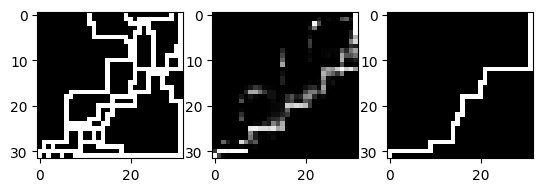

Epoch: 96 	Training Loss: 1.282654


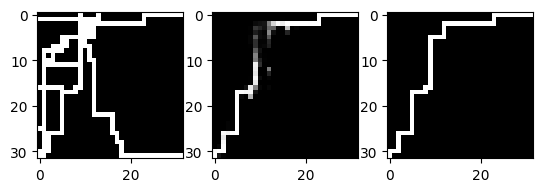

Epoch: 97 	Training Loss: 1.276099


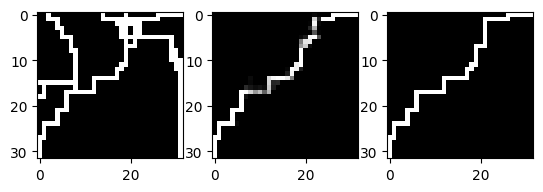

Epoch: 98 	Training Loss: 1.269833


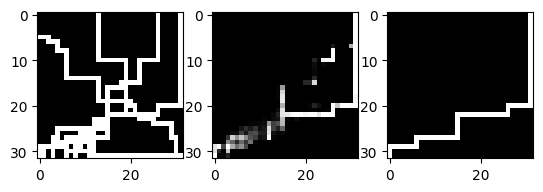

Epoch: 99 	Training Loss: 1.263884


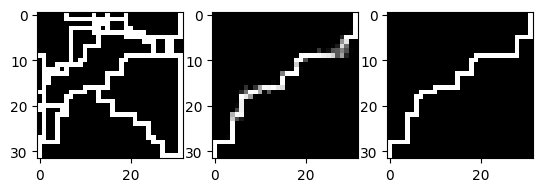

Epoch: 100 	Training Loss: 1.258321


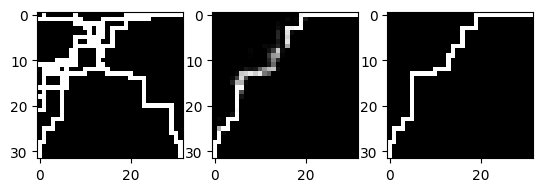

In [7]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#--------------
# Testing
#--------------

def testModel():
    testMaze=torch.ones(1,n,n)
    testSol=torch.ones(n,n) 

    testSol=generate_Solution(n-1,0,n,testSol)
    testMaze[0] = generate_Problem(n-1,0,n,testSol.clone())
    testSolved = model(testMaze).detach().numpy()

    fig, axes = plt.subplots(1,3)
    axes[0].imshow(testMaze[0,:,:],cmap='binary')
    axes[1].imshow(testSolved[0,:,:],cmap='binary')
    axes[2].imshow(testSol,cmap='binary')
    
    plt.show()

#----------------------------
# Set Device
# and transfer the inputs to
# the device
#----------------------------

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

#--------------
# Training
#--------------

epochs = 100
lossList=[]
epochList=[]
for epoch in range(1, epochs+1):
    # monitor training loss
    trainLoss = 0.0
    for images, targets in dataloader:
        # images are mazes with noise
        # targets are mazes without noise
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item()*images.size(0)
          
    trainLoss = trainLoss/len(dataloader)
    lossList.append(trainLoss)
    epochList.append(epochs)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, trainLoss))
    testModel()

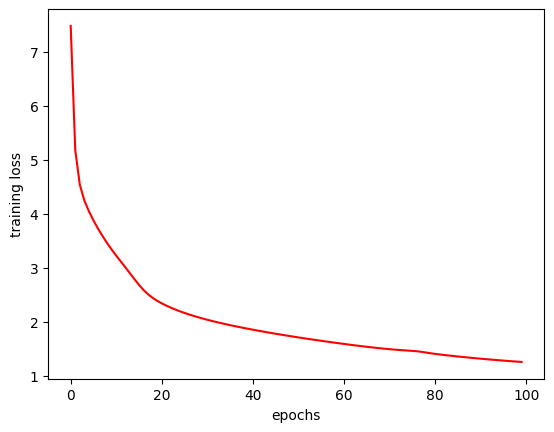

In [8]:
#----------------------------
# Loss vs Epoch graph
#----------------------------
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(lossList,color='red')
plt.show()

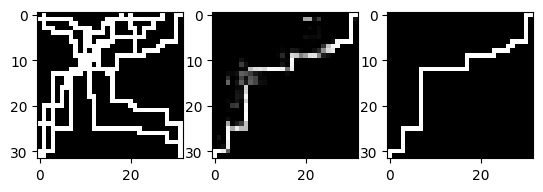

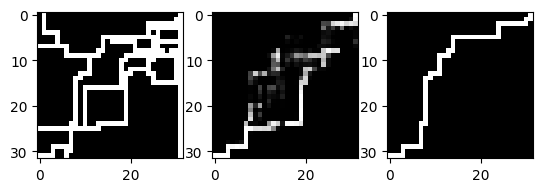

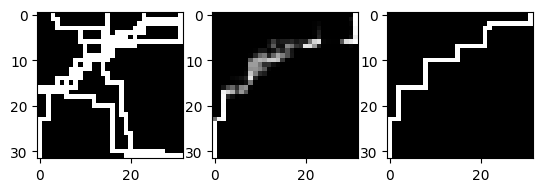

In [9]:
#----------------------------
# Testing is done for 3 images
#----------------------------

for i in range(3):
    testModel()